# A3: Student Behavior Clustering and Statistical Analysis

**Purpose:** This notebook performs unsupervised clustering of students based on their learning behavior patterns and validates the identified clusters through statistical analysis. It uses K-Means clustering on PCA-reduced features and evaluates cluster validity using MANOVA, ANOVA, and post-hoc tests.

## Analysis Pipeline

1. **Data Preparation**: Load and combine summary data across year pairs
2. **Feature Engineering**: Filter features, scale data, apply PCA
3. **Clustering**: Determine optimal K using elbow method, apply K-Means
4. **Statistical Validation**: MANOVA, ANOVA, and Tukey HSD post-hoc tests
5. **Academic Performance Analysis**: ANOVA comparing grades across clusters
6. **Cross-Cohort Comparison**: T-tests comparing performance between academic years

## Key Statistical Methods

| Method | Purpose | Effect Size |
|--------|---------|-------------|
| K-Means | Cluster students by behavior patterns | WCSS (elbow) |
| MANOVA | Test multivariate differences between clusters | Wilks' λ, partial η² |
| ANOVA | Test univariate differences per feature | partial η² |
| Tukey HSD | Pairwise cluster comparisons | Mean differences |
| T-test | Compare cohorts across years | Cohen's d |

## 1. Environment Setup

Import required libraries for clustering, statistical analysis, and visualization.

| Library | Purpose |
|---------|--------|
| `sklearn` | K-Means clustering, PCA, StandardScaler |
| `pingouin` | ANOVA, t-tests, Tukey HSD |
| `statsmodels` | MANOVA |
| `seaborn`, `matplotlib` | Visualization |
| `pandas`, `numpy` | Data manipulation |

In [3]:
import glob
import re
import warnings
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.multivariate.manova import MANOVA

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Analysis Configuration

This section centralizes all configurable parameters for the analysis:

| Parameter | Description |
|-----------|-------------|
| `PATH_PATTERN` | Glob pattern to locate summary CSV files |
| `PREFIXES_TO_DROP` | Feature prefixes to exclude from clustering |
| `K_RANGE` | Range of cluster counts to evaluate |
| `OPTIMAL_K` | Selected number of clusters for final analysis |
| `YEAR_PAIRS` | Pairs of academic years to combine for analysis |

In [4]:
# ==============================================================================
# ANALYSIS CONFIGURATION
# ==============================================================================

# File pattern for summary CSVs from A2 pipeline
PATH_PATTERN = 'matrices_out/summary_20*_Hito*.csv'

# Feature prefixes to exclude (low-variance or irrelevant categories)
PREFIXES_TO_DROP = ['Otro_', 'Reunión_', 'Consulta_', 'Cuestionario_']

# K-Means parameter search range
K_RANGE = range(1, 11)

# Optimal number of clusters (determined via elbow method)
OPTIMAL_K = 3

# Year pairs to combine for cross-cohort analysis
YEAR_PAIRS_TO_CREATE = [(2022, 2023), (2024, 2025)]

# Evaluation columns to merge from matrix files
EVALUATION_COLUMNS = [
    'Hito 1', 'Hito 2', 'Hito 3', 'Trabajo',
    'Coevaluación 1', 'Coevaluación 2', 'Coevaluación 3', 'Asistencia'
]

# Missing value threshold for feature exclusion
MISSING_THRESHOLD = 0.50  # Exclude features with >50% missing

## 3. Data Loading Functions

These functions handle data preparation:

1. **`load_and_prepare_data`**: Discovers summary files, groups by milestone, and combines year pairs into analysis datasets
2. Applies column filtering to remove specified feature prefixes
3. Returns a dictionary of DataFrames keyed by analysis label (e.g., "Hito1_2022-2023")

In [5]:
def load_and_prepare_data(path_pattern: str, prefixes_to_drop: list) -> dict:
    """
    Load summary files and combine into year-pair datasets.
    
    Discovers all summary CSV files matching the pattern, groups them by
    milestone (Hito), and creates combined DataFrames for each specified
    year pair.
    
    Parameters
    ----------
    path_pattern : str
        Glob pattern to find summary CSV files.
    prefixes_to_drop : list of str
        Column prefixes to exclude from the data.
    
    Returns
    -------
    dict
        Mapping of analysis labels to DataFrames.
        Keys follow format: "Hito{N}_{year1}-{year2}"
    
    Raises
    ------
    FileNotFoundError
        If no files match the pattern.
    """
    file_paths = sorted(glob.glob(path_pattern))
    if not file_paths:
        raise FileNotFoundError(f"No files found matching pattern: {path_pattern}")
    
    # Group files by milestone
    hito_groups = defaultdict(list)
    for path in file_paths:
        match = re.search(r'summary_(\d{4})_(Hito\d)', path)
        if match:
            year, hito = match.groups()
            hito_groups[hito].append((int(year), path))
    
    prepared_data = {}
    
    # Create combined datasets for each year pair
    for hito, files_in_hito in hito_groups.items():
        path_dict = dict(files_in_hito)
        
        for year1, year2 in YEAR_PAIRS_TO_CREATE:
            if year1 in path_dict and year2 in path_dict:
                label = f"{hito}_{year1}-{year2}"
                print(f"Creating dataset: {label}")
                
                df1 = pd.read_csv(path_dict[year1])
                df2 = pd.read_csv(path_dict[year2])
                merged_df = pd.concat([df1, df2], ignore_index=True)
                
                # Remove specified column prefixes
                cols_to_drop = [
                    col for col in merged_df.columns
                    if any(col.startswith(p) for p in prefixes_to_drop)
                ]
                merged_df = merged_df.drop(columns=cols_to_drop)
                
                prepared_data[label] = merged_df
            else:
                print(f"WARNING: Missing files for pair {year1}-{year2} in {hito}. Skipping.")
    
    return prepared_data

## 4. Clustering Analysis Function

The `analyze_and_plot_clusters` function performs the complete clustering workflow:

### Steps
1. **Data Cleaning**: Remove Student_ID, fill missing values with 0
2. **Standardization**: Apply StandardScaler for zero mean, unit variance
3. **Dimensionality Reduction**: PCA to 2 components for visualization
4. **Elbow Method**: Compute WCSS for k=1 to 10 to identify optimal K
5. **K-Means Clustering**: Apply with optimal K, random_state=42 for reproducibility
6. **Visualization**: Generate elbow plot, feature importance bars, and PCA scatter

### Outputs
- Elbow plot showing WCSS vs. number of clusters
- Bar chart of mean Z-scores per feature per cluster
- PCA scatter plot colored by cluster assignment

In [17]:
def analyze_and_plot_clusters(
    df: pd.DataFrame,
    label: str,
    axes: tuple,
    k_range: range,
    optimal_k: int
) -> np.ndarray:
    """
    Perform K-Means clustering with PCA visualization.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input data with behavioral features.
    label : str
        Analysis label for plot titles.
    axes : tuple of matplotlib.axes.Axes
        Three axes for (elbow, bar, scatter) plots.
    k_range : range
        Range of K values to test for elbow method.
    optimal_k : int
        Number of clusters for final assignment.
    
    Returns
    -------
    np.ndarray
        Cluster assignments for each row.
    """
    ax_elbow, ax_bar, ax_pca = axes
    
    # Step 1: Clean and scale data
    df_clean = df.drop(columns=['Student_ID'], errors='ignore').fillna(0)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_clean)
    
    # Step 2: PCA dimensionality reduction
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)
    
    # Step 3: Elbow plot
    inertias = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(pca_result)
        inertias.append(kmeans.inertia_)
    
    ax_elbow.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    ax_elbow.set_title(f"Elbow Plot: {label}", fontsize=12, fontweight='bold')
    ax_elbow.set_xlabel("Number of Clusters (k)")
    ax_elbow.set_ylabel("Within-Cluster Sum of Squares (WCSS)")
    ax_elbow.grid(True, alpha=0.3)
    ax_elbow.axvline(x=optimal_k, color='red', linestyle='--', label=f'Selected k={optimal_k}')
    ax_elbow.legend()
    
    # Step 4: Apply K-Means with optimal K
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
    clusters = kmeans.fit_predict(pca_result)
    
    # Step 5: Feature importance bar chart
    df_scaled = pd.DataFrame(scaled_data, columns=df_clean.columns)
    df_scaled['Cluster'] = clusters
    cluster_zscores = df_scaled.groupby('Cluster').mean()
    
    melted_z = cluster_zscores.melt(
        ignore_index=False,
        var_name='Feature',
        value_name='Z-Score Mean'
    ).reset_index()
    
    sns.barplot(
        data=melted_z,
        x='Feature',
        y='Z-Score Mean',
        hue='Cluster',
        ax=ax_bar
    )
    ax_bar.set_title(f"{label} — Feature Z-Scores by Cluster", fontsize=12, fontweight='bold')
    ax_bar.tick_params(axis='x', rotation=90)
    ax_bar.legend(title='Cluster')
    ax_bar.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # Step 6: PCA scatter plot
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
    pca_df['Cluster'] = clusters
    
    sns.scatterplot(
        data=pca_df,
        x='PC1',
        y='PC2',
        hue='Cluster',
        palette='Set2',
        ax=ax_pca,
        s=60,
        alpha=0.8
    )
    ax_pca.set_title(f"{label} — PCA Cluster Visualization", fontsize=12, fontweight='bold')
    ax_pca.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax_pca.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    ax_pca.grid(True, alpha=0.3)
    ax_pca.legend(title='Cluster')
    
    return clusters

## 5. Execute Clustering Pipeline

This section orchestrates the clustering analysis:

1. Load and prepare data for all year-pair combinations
2. Create visualization subplots for each dataset
3. Run clustering analysis and store cluster assignments
4. Display all visualizations in a "small multiples" format

Creating dataset: Hito1_2022-2023
Creating dataset: Hito1_2024-2025
Creating dataset: Hito2_2022-2023
Creating dataset: Hito2_2024-2025
Creating dataset: Hito3_2022-2023
Creating dataset: Hito3_2024-2025

Analyzing: Hito1_2022-2023...

Analyzing: Hito1_2024-2025...

Analyzing: Hito2_2022-2023...

Analyzing: Hito2_2024-2025...

Analyzing: Hito3_2022-2023...

Analyzing: Hito3_2024-2025...


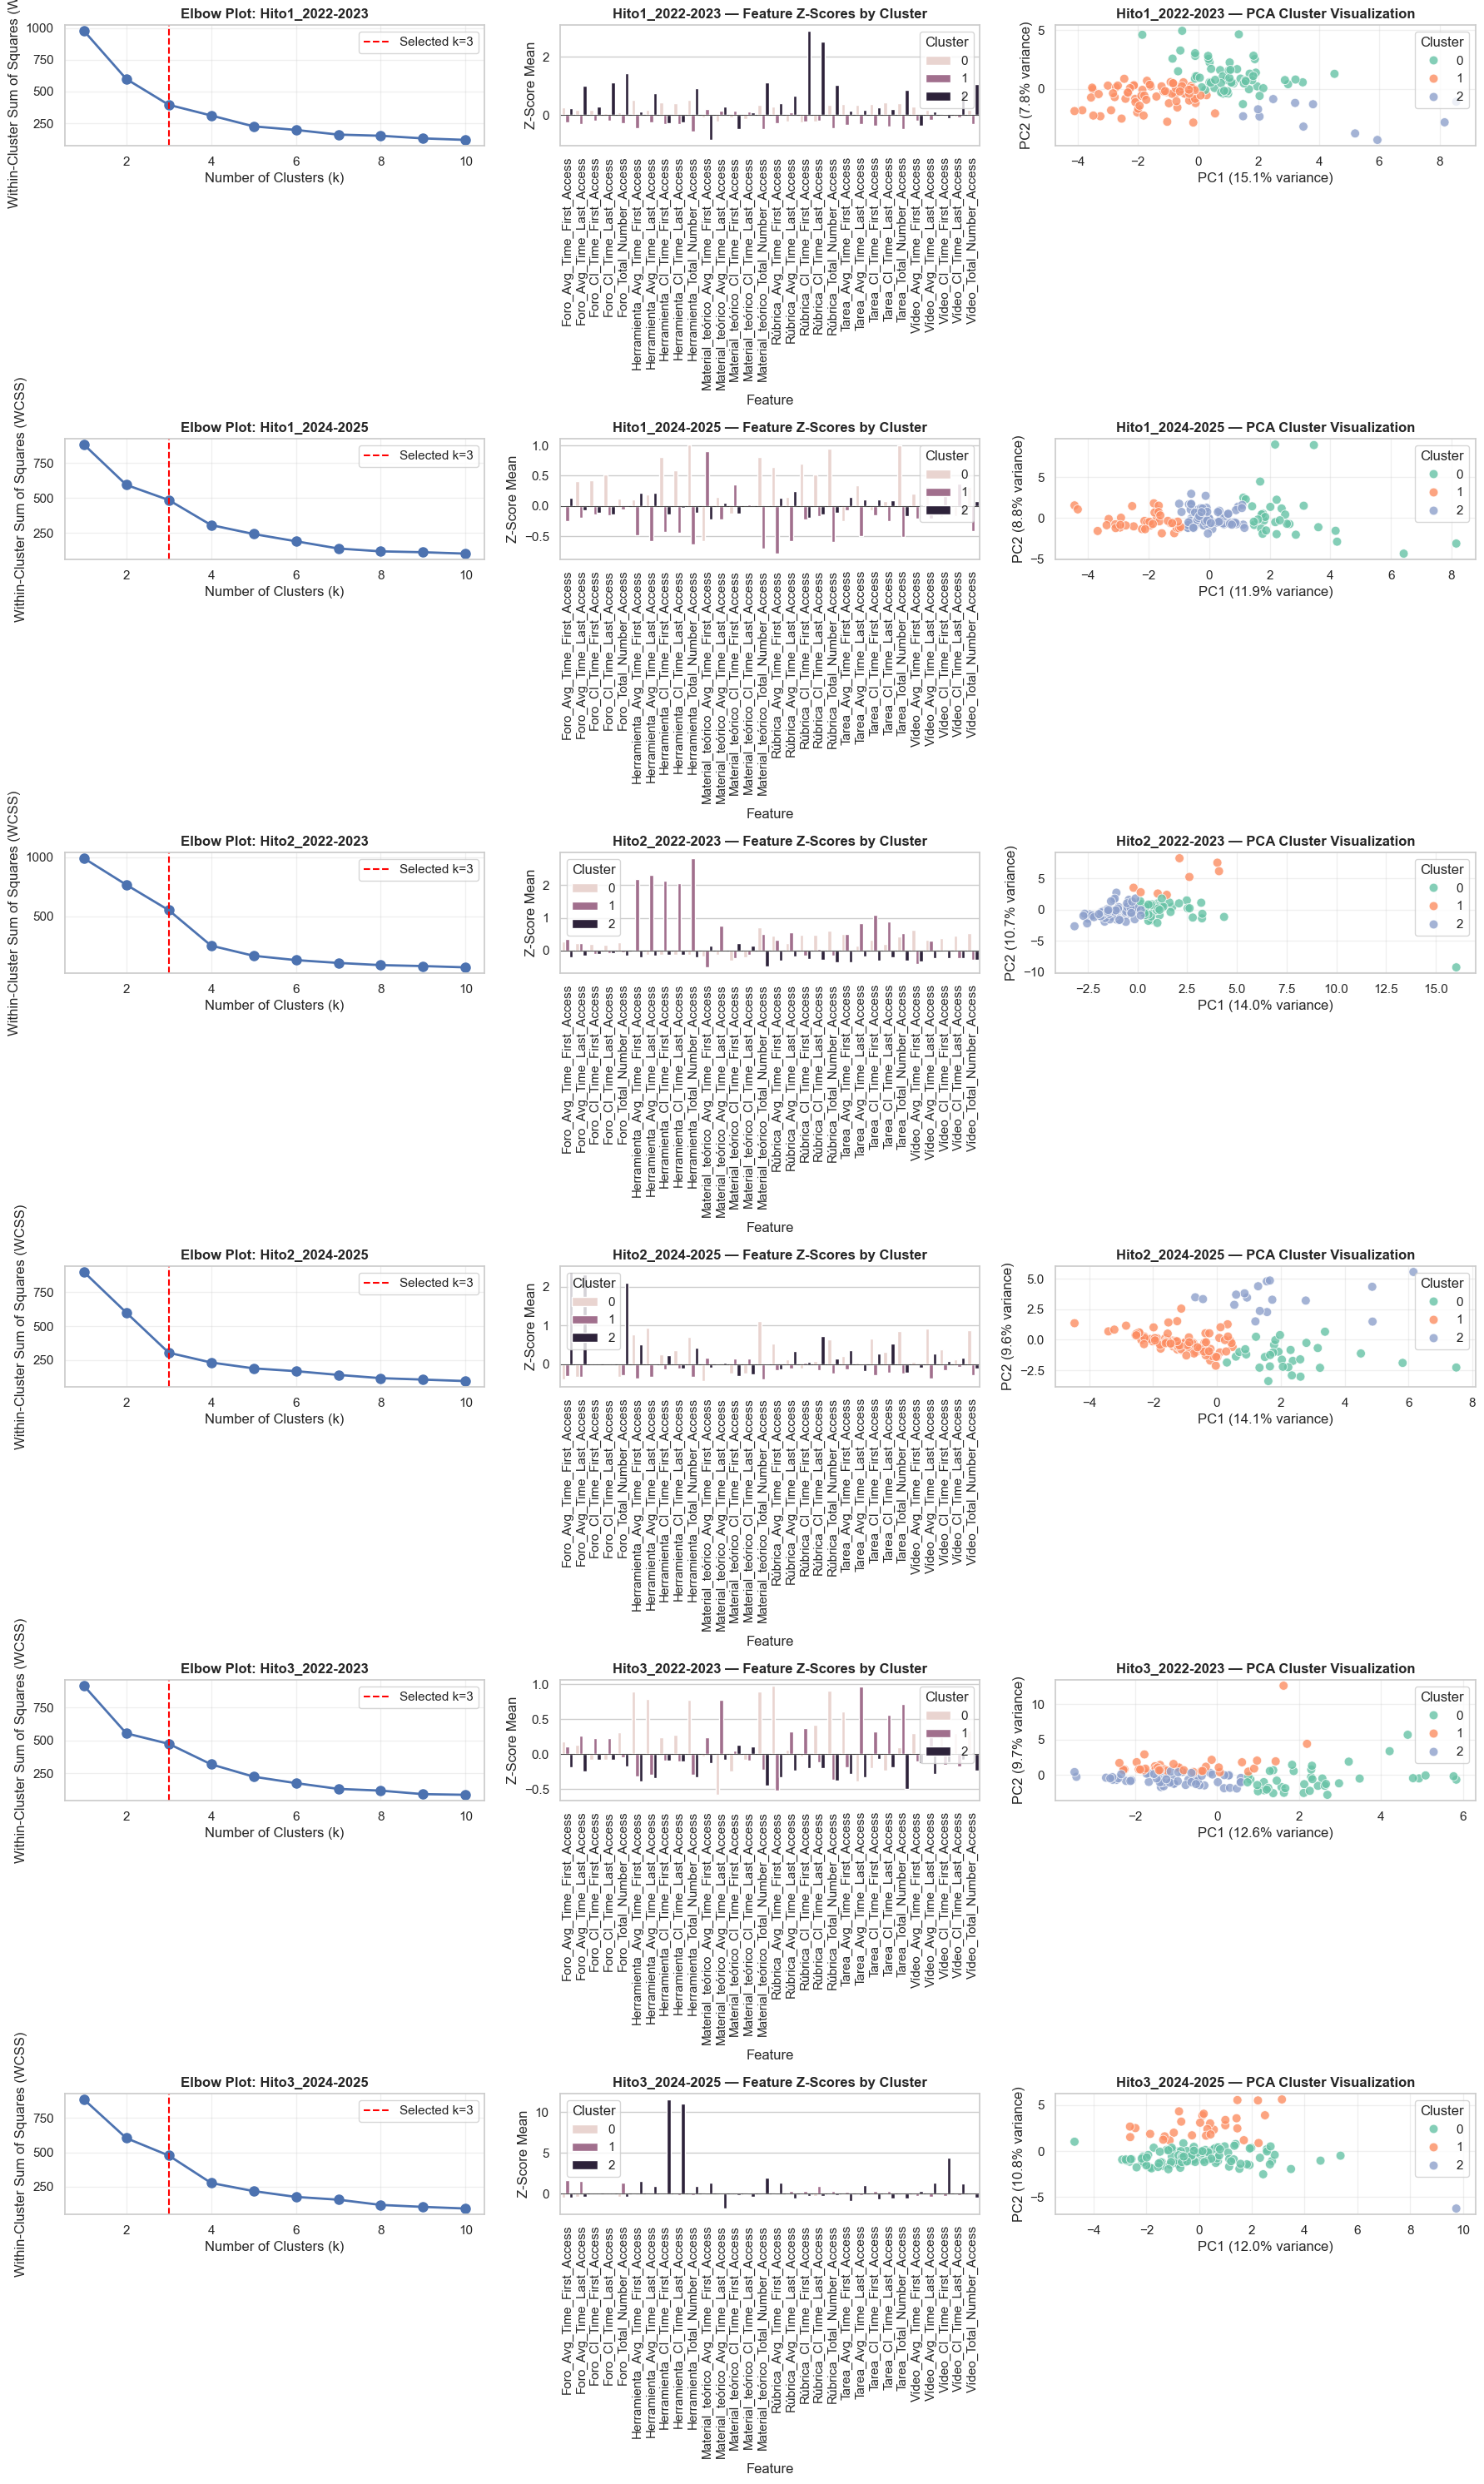


Clustering analysis complete. Results saved to 'clustering_overview.png'


In [18]:
# Load and prepare data
prepared_data = load_and_prepare_data(PATH_PATTERN, PREFIXES_TO_DROP)

# Create figure with subplots for all datasets
n_datasets = len(prepared_data)
fig, axes = plt.subplots(
    n_datasets, 3,
    figsize=(18, 5 * n_datasets),
    squeeze=False
)

# Run clustering for each dataset
for idx, (label, df) in enumerate(prepared_data.items()):
    print(f"\nAnalyzing: {label}...")
    
    clusters = analyze_and_plot_clusters(
        df=df,
        label=label,
        axes=(axes[idx, 0], axes[idx, 1], axes[idx, 2]),
        k_range=K_RANGE,
        optimal_k=OPTIMAL_K
    )
    
    # Store cluster assignments in the DataFrame
    prepared_data[label] = df.assign(Cluster=clusters)

plt.tight_layout()
plt.savefig('clustering_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClustering analysis complete. Results saved to 'clustering_overview.png'")

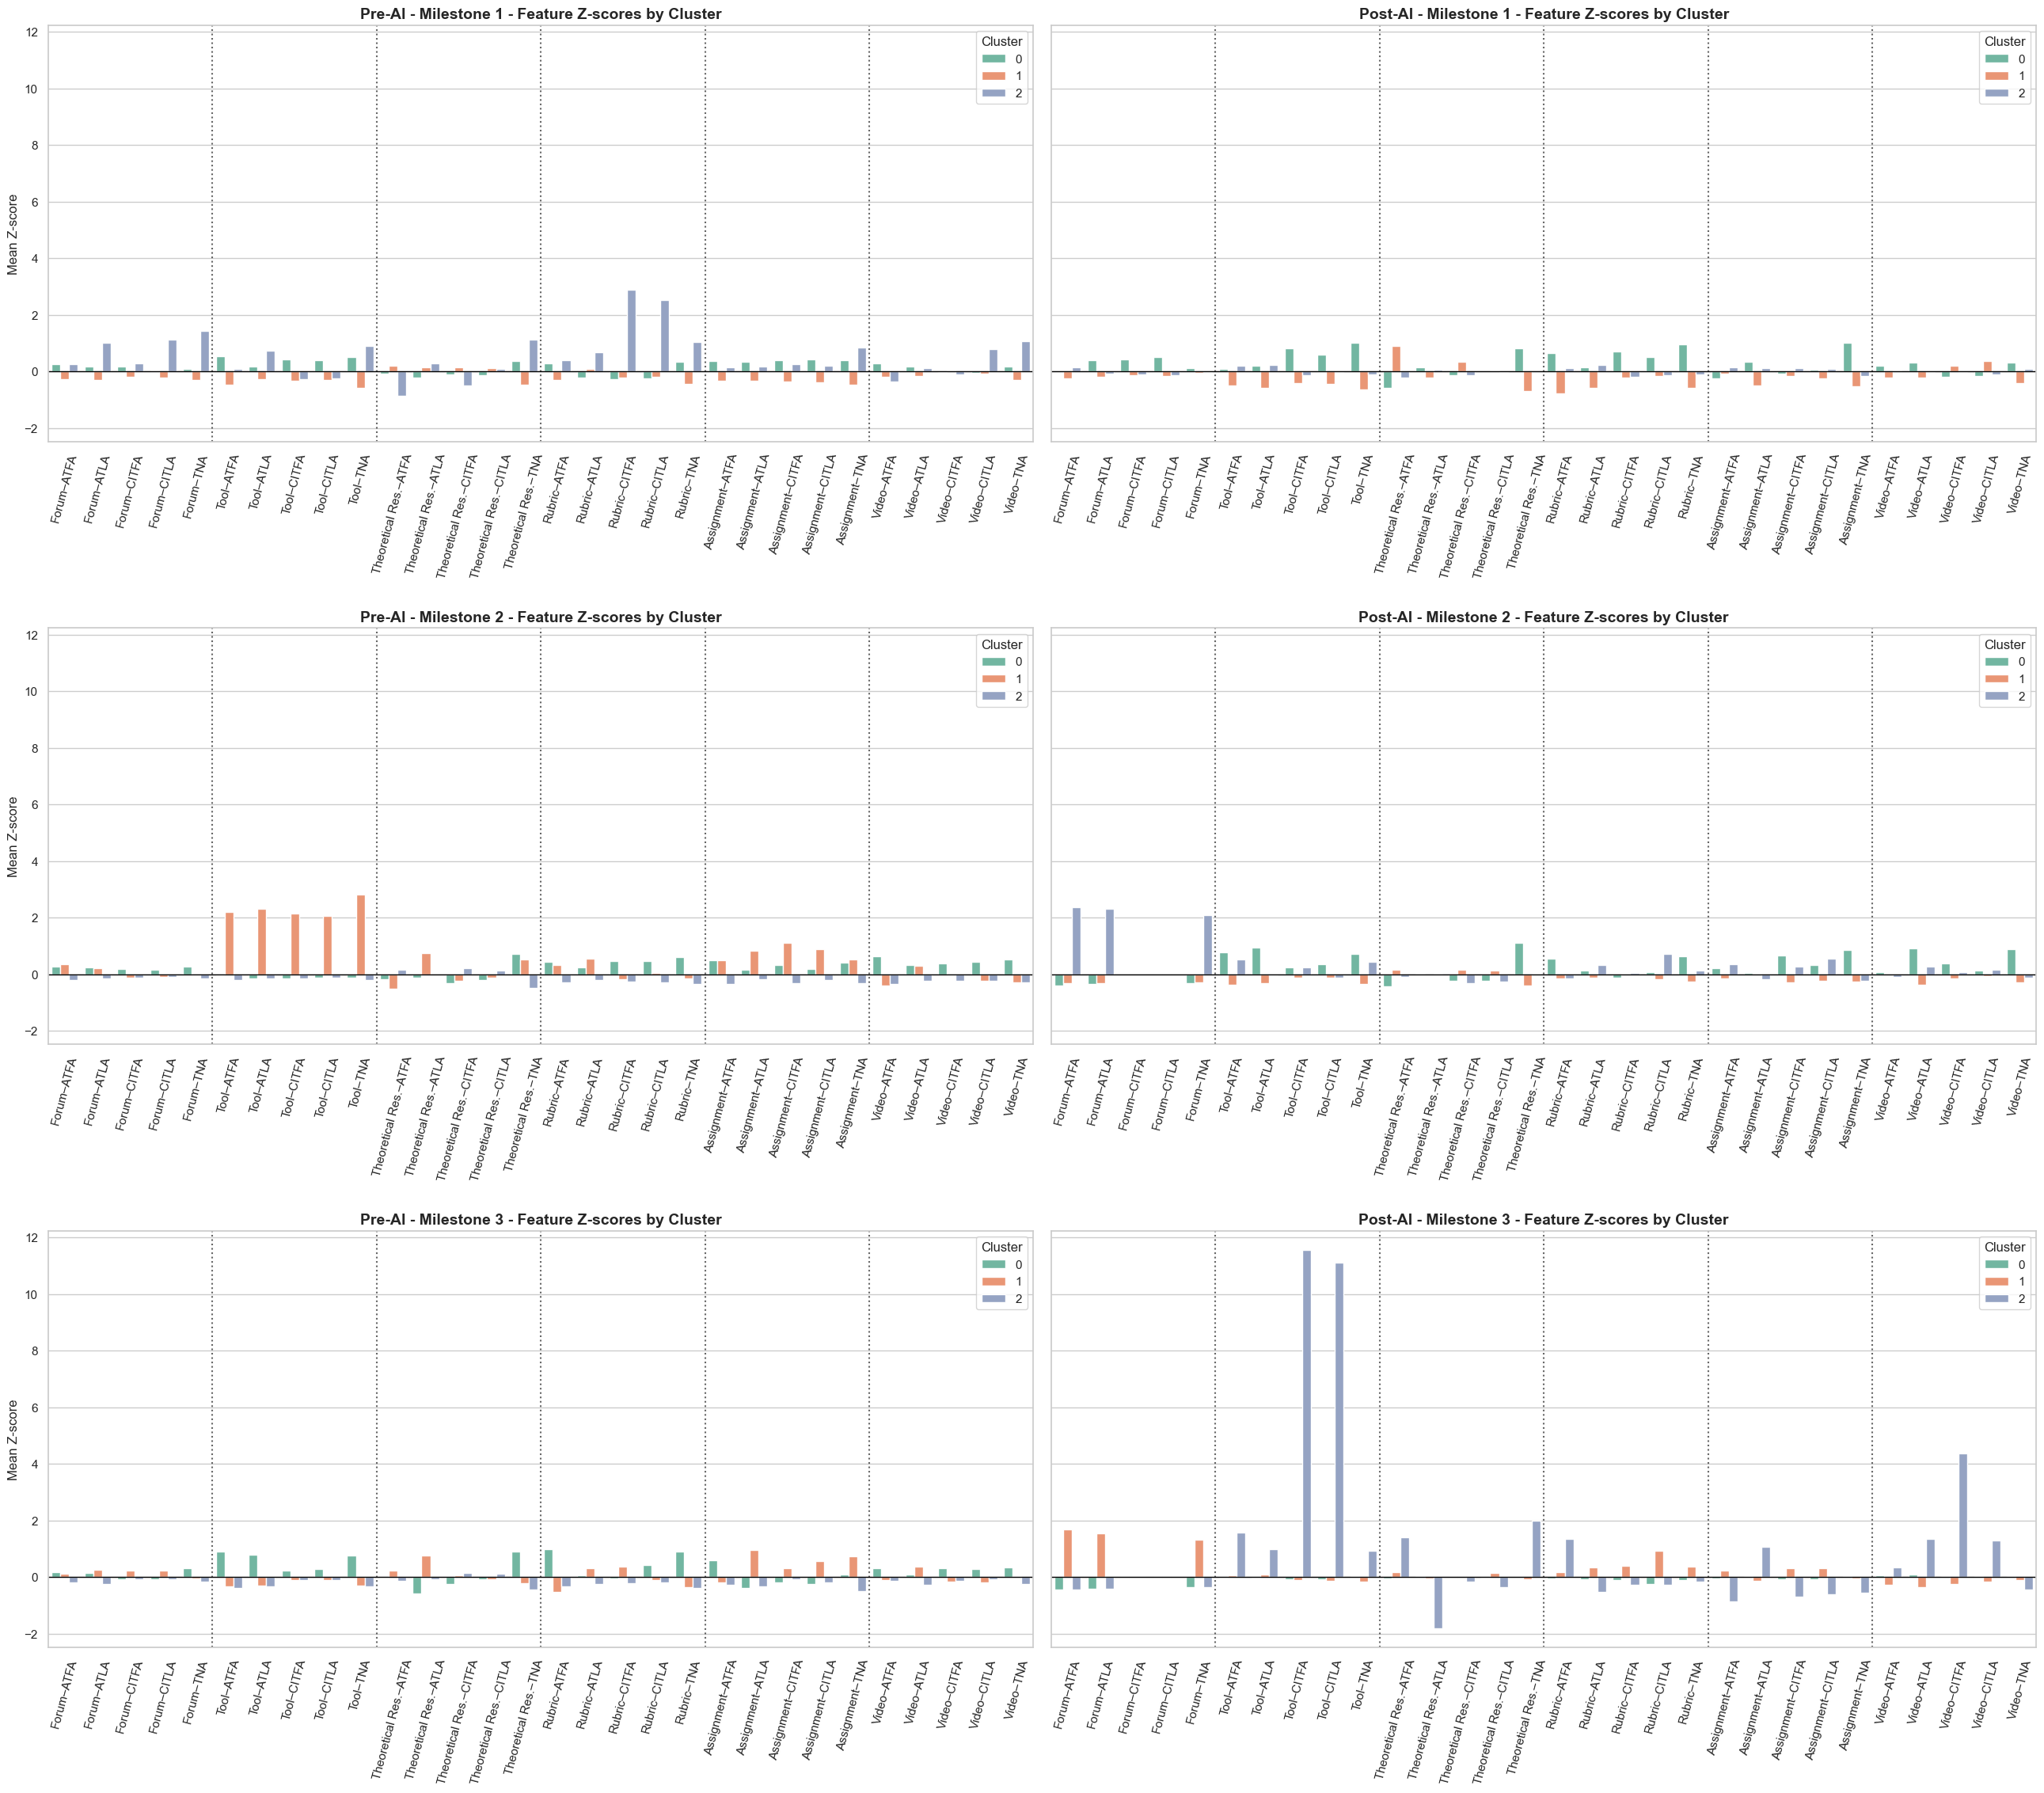

In [34]:
METRIC_CODES = {
    "Avg. Time to First Access": "ATFA",
    "Avg. Time to Last Access": "ATLA",
    "CI Time to First Access": "CITFA",
    "CI Time to Last Access": "CITLA",
    "Total Number of Accesses": "TNA"
}

SET2_PALETTE = sns.color_palette("Set2")
CLUSTER_PALETTE = {
    0: SET2_PALETTE[0],
    1: SET2_PALETTE[1],
    2: SET2_PALETTE[2],
}

LABEL_TRANSLATIONS = {
    "Foro_Avg_Time_First_Access": "Forum – Avg. Time to First Access",
    "Foro_Avg_Time_Last_Access": "Forum – Avg. Time to Last Access",
    "Foro_CI_Time_First_Access": "Forum – CI Time to First Access",
    "Foro_CI_Time_Last_Access": "Forum – CI Time to Last Access",
    "Foro_Total_Number_Access": "Forum – Total Number of Accesses",

    "Herramienta_Avg_Time_First_Access": "Tool – Avg. Time to First Access",
    "Herramienta_Avg_Time_Last_Access": "Tool – Avg. Time to Last Access",
    "Herramienta_CI_Time_First_Access": "Tool – CI Time to First Access",
    "Herramienta_CI_Time_Last_Access": "Tool – CI Time to Last Access",
    "Herramienta_Total_Number_Access": "Tool – Total Number of Accesses",

    "Material_teórico_Avg_Time_First_Access": "Theoretical Res. – Avg. Time to First Access",
    "Material_teórico_Avg_Time_Last_Access": "Theoretical Res. – Avg. Time to Last Access",
    "Material_teórico_CI_Time_First_Access": "Theoretical Res. – CI Time to First Access",
    "Material_teórico_CI_Time_Last_Access": "Theoretical Res. – CI Time to Last Access",
    "Material_teórico_Total_Number_Access": "Theoretical Res. – Total Number of Accesses",

    "Rúbrica_Avg_Time_First_Access": "Rubric – Avg. Time to First Access",
    "Rúbrica_Avg_Time_Last_Access": "Rubric – Avg. Time to Last Access",
    "Rúbrica_CI_Time_First_Access": "Rubric – CI Time to First Access",
    "Rúbrica_CI_Time_Last_Access": "Rubric – CI Time to Last Access",
    "Rúbrica_Total_Number_Access": "Rubric – Total Number of Accesses",

    "Tarea_Avg_Time_First_Access": "Assignment – Avg. Time to First Access",
    "Tarea_Avg_Time_Last_Access": "Assignment – Avg. Time to Last Access",
    "Tarea_CI_Time_First_Access": "Assignment – CI Time to First Access",
    "Tarea_CI_Time_Last_Access": "Assignment – CI Time to Last Access",
    "Tarea_Total_Number_Access": "Assignment – Total Number of Accesses",

    "Vídeo_Avg_Time_First_Access": "Video – Avg. Time to First Access",
    "Vídeo_Avg_Time_Last_Access": "Video – Avg. Time to Last Access",
    "Vídeo_CI_Time_First_Access": "Video – CI Time to First Access",
    "Vídeo_CI_Time_Last_Access": "Video – CI Time to Last Access",
    "Vídeo_Total_Number_Access": "Video – Total Number of Accesses",
}

def translate_label(label):
    return LABEL_TRANSLATIONS.get(label, label)

def extract_resource_type(feature):
    return feature.split(" – ")[0]

def compact_feature_label(feature):
    """
    Convert 'Forum – Avg. Time to First Access'
    to 'Forum–ATFA'
    """
    if " – " not in feature:
        return feature

    resource, metric = feature.split(" – ", 1)
    metric_code = METRIC_CODES.get(metric, metric)
    return f"{resource}–{metric_code}"


sns.set_theme(style="whitegrid")

labels = list(prepared_data.keys())
rows = sorted(set(l.split('_')[0] for l in labels))
cols = sorted(set(l.split('_')[1] for l in labels))

fig, axes = plt.subplots(
    len(rows),
    len(cols),
    figsize=(26, 7 * len(rows)),
    squeeze=False,
    sharey=True
)


for i, row in enumerate(rows):
    for j, col in enumerate(cols):

        label = f"{row}_{col}"
        ax = axes[i, j]

        df = prepared_data[label]

        # Obtener columnas de features (excluyendo Cluster y Student_ID)
        feature_cols = (
            df.select_dtypes(include='number')
              .columns
              .drop(['Cluster'], errors='ignore')
        )
        
        # Limpiar datos (igual que en Enfoque 1)
        df_clean = df[feature_cols].fillna(0)
        
        # Escalar datos (igual que en Enfoque 1)
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df_clean)
        
        # Crear DataFrame con datos escalados y clusters
        df_scaled = pd.DataFrame(scaled_data, columns=feature_cols)
        df_scaled['Cluster'] = df['Cluster'].values
        
        # Calcular medias por cluster (igual que en Enfoque 1)
        cluster_means = df_scaled.groupby('Cluster').mean()
        
        # Transformar a formato largo para el gráfico
        cluster_means = (
            cluster_means
            .reset_index()
            .melt(
                id_vars='Cluster',
                var_name='Feature',
                value_name='Mean Z-score'
            )
        )

        # Translate + extract resource type
        cluster_means['Feature'] = cluster_means['Feature'].apply(translate_label)
        cluster_means['Resource'] = cluster_means['Feature'].apply(extract_resource_type)
        cluster_means['Feature'] = cluster_means['Feature'].apply(compact_feature_label)

        sns.barplot(
            data=cluster_means,
            x='Feature',
            y='Mean Z-score',
            hue='Cluster',
            palette=CLUSTER_PALETTE,
            ax=ax
        )

        if row == "Hito1":
            milestone = "Milestone 1"
        elif row == "Hito2":
            milestone = "Milestone 2"
        else:
            milestone = "Milestone 3"

        if col == "2022-2023":
            cohort = "Pre-AI"
        else:
            cohort = "Post-AI"

        ax.axhline(0, color='black', linewidth=1)
        ax.set_title(f"{cohort} - {milestone} - Feature Z-scores by Cluster", fontsize=14, fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("Mean Z-score")
        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=75,
            ha='center',
            fontsize=11
        )
        ax.legend(title='Cluster', loc='upper right')

        resource_changes = (
            cluster_means[['Feature', 'Resource']]
            .drop_duplicates()
            .reset_index(drop=True)
        )

        for idx_r in range(1, len(resource_changes)):
            if resource_changes.loc[idx_r, 'Resource'] != resource_changes.loc[idx_r - 1, 'Resource']:
                ax.axvline(idx_r - 0.5, color='black', linestyle=':', alpha=0.6)

plt.tight_layout()
plt.subplots_adjust(bottom=0.005)
plt.savefig("zscore_barplots_detail.png", dpi=300, bbox_inches='tight')
plt.show()

## 6. Statistical Validation of Clusters

This section validates the clustering results using rigorous statistical methods:

### MANOVA (Multivariate Analysis of Variance)
- Tests whether cluster centroids differ significantly across all features simultaneously
- Reports Wilks' λ, F-statistic, and p-value
- Effect size: partial η² = 1 - Wilks' λ

### ANOVA (Per-Feature)
- Identifies which specific features contribute most to cluster differentiation
- Reports F-statistic, p-value, and partial η² for each feature
- Features ranked by effect size

### Tukey HSD Post-Hoc
- Performs pairwise comparisons between clusters for significant features
- Controls family-wise error rate
- Reports mean differences and adjusted p-values

### Effect Size Interpretation (Cohen, 1988)
| partial η² | Interpretation |
|------------|----------------|
| ≥ 0.14 | Large effect |
| ≥ 0.06 | Medium effect |
| ≥ 0.01 | Small effect |
| < 0.01 | Trivial effect |

In [ ]:
def run_statistical_validation(df: pd.DataFrame, label: str) -> dict:
    """
    Perform comprehensive statistical validation of cluster assignments.
    
    Parameters
    ----------
    df : pd.DataFrame
        Data with 'Cluster' column and behavioral features.
    label : str
        Analysis label for reporting.
    
    Returns
    -------
    dict
        Dictionary containing MANOVA and ANOVA results.
    """
    print(f"\n{'='*70}")
    print(f"STATISTICAL VALIDATION FOR: {label}")
    print('='*70)
    
    if 'Cluster' not in df.columns:
        print(f"WARNING: No 'Cluster' column found. Skipping.")
        return {}
    
    results = {'label': label}
    
    # Prepare feature matrix
    feature_cols = df.drop(columns=['Student_ID', 'Cluster'], errors='ignore').columns
    independent_vars = df[feature_cols].fillna(0)
    
    # Filter features with excessive missing values
    missing_pct = (df[feature_cols].isnull().sum() / len(df) * 100)
    high_missing = missing_pct[missing_pct > MISSING_THRESHOLD * 100].index.tolist()
    
    if high_missing:
        print(f"\nINFO: Excluding {len(high_missing)} features with >{MISSING_THRESHOLD:.0%} missing:")
        for feat in high_missing[:5]:
            print(f"  - {feat} ({missing_pct[feat]:.1f}% missing)")
        if len(high_missing) > 5:
            print(f"  ... and {len(high_missing) - 5} more")
        
        independent_vars = independent_vars.drop(columns=high_missing)
        print(f"Features retained: {independent_vars.shape[1]}")
    
    # Remove constant columns
    variance = independent_vars.var()
    constant_cols = variance[variance == 0].index.tolist()
    if constant_cols:
        print(f"INFO: Removing {len(constant_cols)} constant columns")
        independent_vars = independent_vars.drop(columns=constant_cols)
    
    if independent_vars.shape[1] < 1:
        print("WARNING: No features remaining for analysis.")
        return results
    
    # Scale features
    scaler = StandardScaler()
    scaled_vars = scaler.fit_transform(independent_vars)
    df_scaled = pd.DataFrame(scaled_vars, columns=independent_vars.columns)
    
    # =========================================================================
    # STEP 1: MANOVA
    # =========================================================================
    print(f"\n--- STEP 1: MANOVA (Multivariate Test) ---")
    print("Tests whether behavioral features differ significantly across clusters.")
    
    df_manova = pd.concat([df_scaled, df['Cluster'].reset_index(drop=True)], axis=1)
    df_manova['Cluster'] = df_manova['Cluster'].astype('category')
    
    formula = ' + '.join(independent_vars.columns) + ' ~ Cluster'
    
    try:
        manova_test = MANOVA.from_formula(formula, data=df_manova)
        manova_results = manova_test.mv_test()
        
        wilks = manova_results.summary_frame.loc['Cluster', "Wilks' lambda"]
        p_value = wilks['Pr > F']
        wilks_value = wilks['Value']
        f_value = wilks['F Value']
        
        print(f"\nWilks' lambda results:")
        print(f"  Wilks' λ = {wilks_value:.4f}")
        print(f"  F-statistic = {f_value:.2f}")
        print(f"  p-value = {p_value:.6f}")
        
        if 0 <= wilks_value <= 1:
            # Interpret p-value
            if p_value < 0.001:
                print(f"\nInterpretation: Highly significant (p < 0.001)")
            elif p_value < 0.05:
                print(f"\nInterpretation: Significant (p < 0.05)")
            else:
                print(f"\nInterpretation: Not significant (p ≥ 0.05)")
            
            # Effect size
            partial_eta_sq = 1 - wilks_value
            print(f"\nEffect size (partial η²): {partial_eta_sq:.4f}")
            
            if partial_eta_sq >= 0.14:
                effect_label = 'LARGE'
            elif partial_eta_sq >= 0.06:
                effect_label = 'MEDIUM'
            elif partial_eta_sq >= 0.01:
                effect_label = 'SMALL'
            else:
                effect_label = 'trivial'
            print(f"Interpretation: {effect_label} effect")
            
            results['manova'] = {
                'wilks_lambda': wilks_value,
                'f_value': f_value,
                'p_value': p_value,
                'partial_eta_sq': partial_eta_sq
            }
        else:
            print(f"\n⚠️ WARNING: Wilks' λ out of valid range [0,1]")
            print("   Consider reducing features or using PCA preprocessing.")
            
    except Exception as e:
        print(f"MANOVA failed: {e}")
        print("Proceeding with univariate ANOVAs only.")
    
    # =========================================================================
    # STEP 2: ANOVA per feature
    # =========================================================================
    print(f"\n--- STEP 2: ANOVA (Per-Feature Analysis) ---")
    print("Identifies which features contribute most to cluster differences.")
    
    df_anova = pd.concat([independent_vars, df['Cluster'].reset_index(drop=True)], axis=1)
    df_anova['Cluster'] = df_anova['Cluster'].astype('category')
    
    anova_results = []
    for var in independent_vars.columns:
        try:
            result = pg.anova(data=df_anova, dv=var, between='Cluster')
            anova_results.append({
                'Variable': var,
                'F-statistic': result['F'][0],
                'p-value': result['p-unc'][0],
                'Partial η²': result['np2'][0],
                'Significant': 'Yes' if result['p-unc'][0] < 0.05 else 'No'
            })
        except Exception:
            continue
    
    if not anova_results:
        print("No ANOVA results could be computed.")
        return results
    
    results_df = pd.DataFrame(anova_results).sort_values('Partial η²', ascending=False)
    
    print(f"\nTop 10 discriminative features (by effect size):")
    print(results_df.head(10).to_string(index=False))
    
    n_significant = (results_df['Significant'] == 'Yes').sum()
    print(f"\n{n_significant}/{len(results_df)} features show significant differences (p < 0.05)")
    
    results['anova'] = results_df
    
    # =========================================================================
    # STEP 3: Tukey HSD Post-Hoc
    # =========================================================================
    print(f"\n--- STEP 3: Tukey HSD Post-Hoc Comparisons ---")
    significant_vars = results_df[results_df['Significant'] == 'Yes']['Variable'].tolist()
    
    if not significant_vars:
        print("No significant variables for post-hoc analysis.")
    else:
        print(f"Performing pairwise comparisons for {len(significant_vars)} significant variables.")
        print("(Showing top 5 for brevity)\n")
        
        posthoc_results = []
        for i, var in enumerate(significant_vars[:5], 1):
            try:
                posthoc = pg.pairwise_tukey(data=df_anova, dv=var, between='Cluster')
                sig_pairs = posthoc[posthoc['p-tukey'] < 0.05]
                
                if not sig_pairs.empty:
                    print(f"{i}. {var}:")
                    for _, row in sig_pairs.iterrows():
                        print(f"   Cluster {row['A']} vs {row['B']}: "
                              f"diff = {row['diff']:+.3f}, p = {row['p-tukey']:.4f}")
                    print()
                    posthoc_results.append({'variable': var, 'results': sig_pairs})
            except Exception as e:
                print(f"   Error for {var}: {e}")
        
        if len(significant_vars) > 5:
            print(f"... and {len(significant_vars) - 5} additional significant variables")
        
        results['posthoc'] = posthoc_results
    
    print(f"\n{'='*70}")
    print(f"VALIDATION COMPLETE FOR: {label}")
    print('='*70)
    
    return results


# Run statistical validation for all datasets
validation_results = {}
for label, df in prepared_data.items():
    validation_results[label] = run_statistical_validation(df, label)

## 7. Data Enrichment: Adding Evaluation Grades

Before analyzing the relationship between behavior clusters and academic performance, we need to merge evaluation data (grades) with the clustered datasets.

### Methodology
1. Load the detailed matrix files (`matrix_{year}_{hito}.csv`) for each year
2. Extract evaluation columns (Hito grades, project, peer evaluation, attendance)
3. Ensure one row per student using `groupby().first()`
4. Merge evaluation data with summary/cluster data

In [ ]:
print("Starting data enrichment process...")

data_final = {}

for label, summary_df in prepared_data.items():
    print(f"\nProcessing: {label}...")
    
    # Extract year information from label
    match = re.search(r'(Hito\d+)_(\d{4})-(\d{4})', label)
    if not match:
        print(f"  WARNING: Could not parse label '{label}'. Skipping.")
        continue
    
    hito, year1, year2 = match.groups()
    years_to_load = [int(year1), int(year2)]
    
    # Load matrix files for each year
    eval_dfs = []
    for year in years_to_load:
        try:
            path = f'matrices_out/matrix_{year}_{hito}.csv'
            # Handle decimal comma format (common in Spanish locales)
            df = pd.read_csv(path, decimal=',')
            eval_dfs.append(df)
        except FileNotFoundError:
            print(f"  WARNING: File not found: {path}")
            continue
    
    if not eval_dfs:
        print(f"  ERROR: No evaluation data could be loaded for {label}.")
        continue
    
    full_eval_df = pd.concat(eval_dfs, ignore_index=True)
    
    # Prepare evaluation table
    cols_to_keep = ['Student_ID'] + EVALUATION_COLUMNS
    existing_cols = [col for col in cols_to_keep if col in full_eval_df.columns]
    
    if 'Student_ID' not in existing_cols:
        print(f"  ERROR: 'Student_ID' column not found. Skipping.")
        continue
    
    # Get one row per student (first non-null value for each column)
    eval_data = (
        full_eval_df[existing_cols]
        .groupby('Student_ID')
        .first()
        .reset_index()
    )
    
    # Merge with clustered data
    merged_df = pd.merge(
        summary_df,
        eval_data,
        on='Student_ID',
        how='left'
    )
    
    data_final[label] = merged_df
    print(f"  ✓ Complete! Final DataFrame has {merged_df.shape[1]} columns.")

print("\nData enrichment complete.")

## 8. Academic Performance Analysis by Cluster

This section tests whether behavioral clusters are associated with different academic outcomes.

### Methodology

For each dataset (milestone × year-pair):

1. **Variable Selection**: Automatically select the corresponding grade column (e.g., "Hito 1" for Hito1 datasets)
2. **Data Validation**: Convert to numeric, exclude missing values
3. **ANOVA**: Test whether mean grades differ across clusters
4. **Tukey HSD**: If ANOVA is significant, identify which cluster pairs differ
5. **Visualization**: Boxplots showing grade distributions by cluster

### Effect Size Interpretation (partial η²)
- ≥ 0.14: Large effect (clusters strongly predict performance)
- ≥ 0.06: Medium effect (moderate relationship)
- ≥ 0.01: Small effect (weak relationship)
- < 0.01: Negligible (clusters don't predict performance)

Analyzing academic performance by cluster...


Performance Analysis: Hito 1 by Cluster (Hito1_2022-2023)

Descriptive Statistics:
         count  mean   std
Cluster                   
0           60  6.33  0.95
1           51  6.59  1.10
2           11  6.73  1.15

--- ANOVA Results ---
    Source  ddof1  ddof2        F     p-unc       np2
0  Cluster      2    119  1.26893  0.284908  0.020881

✗ No significant differences in Hito 1 between clusters (p = 0.2849)


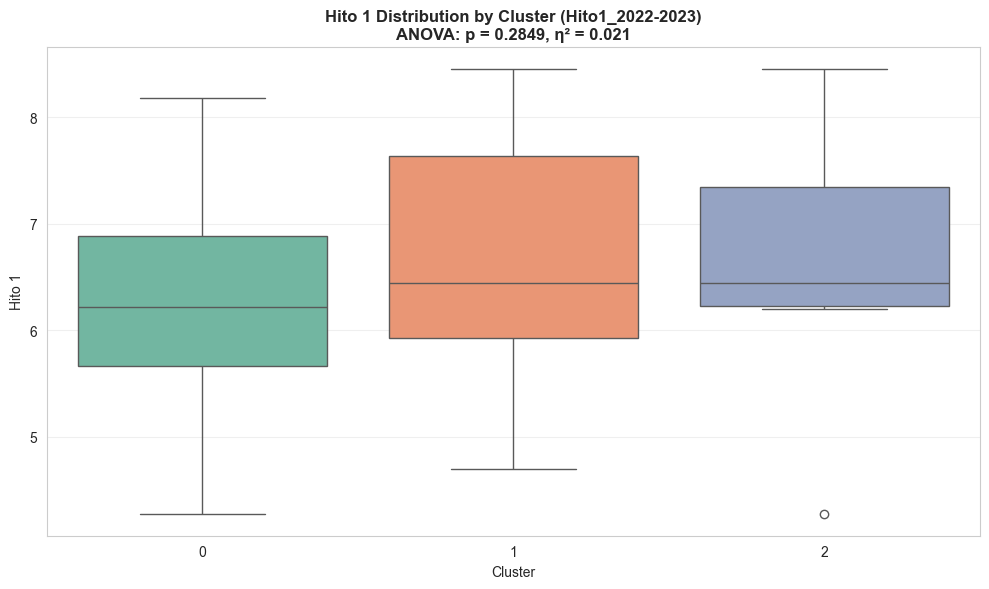


Performance Analysis: Hito 1 by Cluster (Hito1_2024-2025)

Descriptive Statistics:
         count  mean   std
Cluster                   
0           32  6.36  1.67
1           24  4.79  1.69
2           71  5.77  1.60

--- ANOVA Results ---
    Source  ddof1  ddof2         F     p-unc       np2
0  Cluster      2    124  6.343179  0.002383  0.092814

✓ Significant differences found (p = 0.0024)

--- Tukey HSD Post-Hoc ---
   A  B    diff  p-tukey
0  0  1  1.5708   0.0016
1  0  2  0.5984   0.2032
2  1  2 -0.9725   0.0349


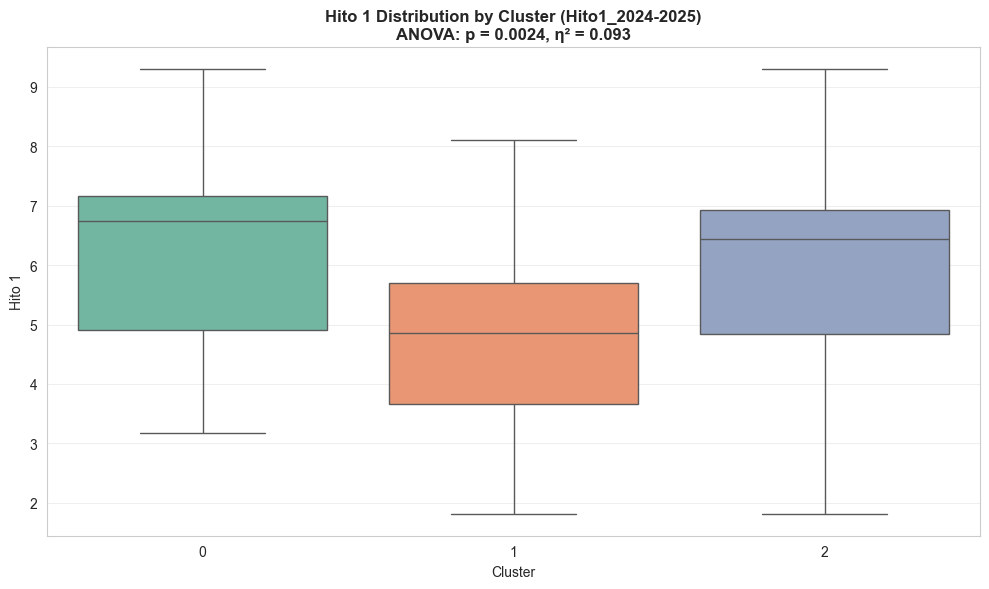


Performance Analysis: Hito 2 by Cluster (Hito2_2022-2023)

Descriptive Statistics:
         count  mean   std
Cluster                   
0           45  7.38  1.80
1            8  6.80  2.30
2           68  6.74  1.67

--- ANOVA Results ---
    Source  ddof1  ddof2         F     p-unc       np2
0  Cluster      2    118  1.870001  0.158662  0.030721

✗ No significant differences in Hito 2 between clusters (p = 0.1587)


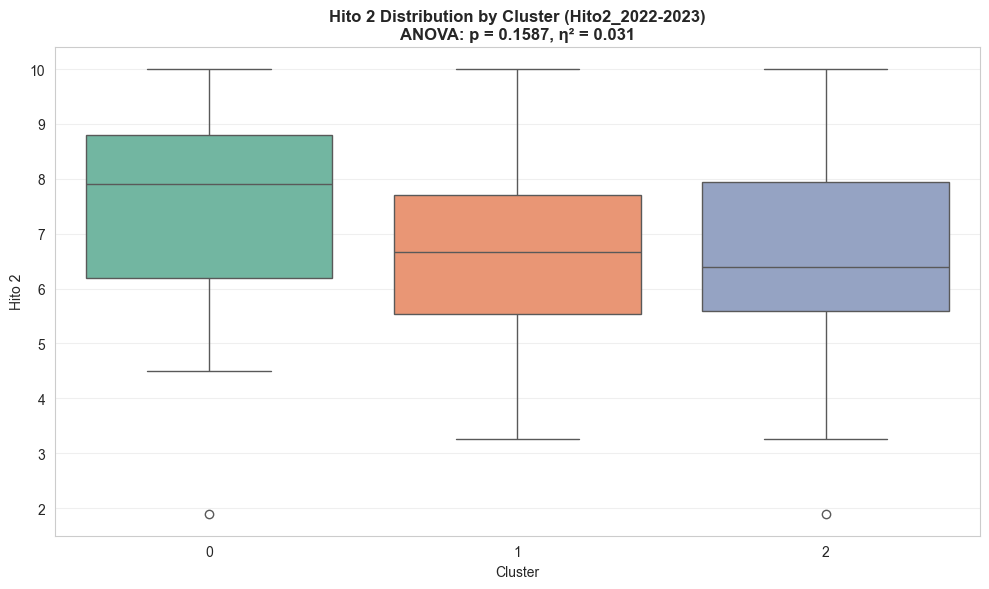


Performance Analysis: Hito 2 by Cluster (Hito2_2024-2025)

Descriptive Statistics:
         count  mean   std
Cluster                   
0           30  8.76  1.33
1           80  8.15  1.36
2           16  7.82  1.45

--- ANOVA Results ---
    Source  ddof1  ddof2         F    p-unc       np2
0  Cluster      2    123  3.075364  0.04974  0.047624

✓ Significant differences found (p = 0.0497)

--- Tukey HSD Post-Hoc ---
   A  B    diff  p-tukey
0  0  1  0.6035   0.1007
1  0  2  0.9379   0.0713
2  1  2  0.3344   0.6440


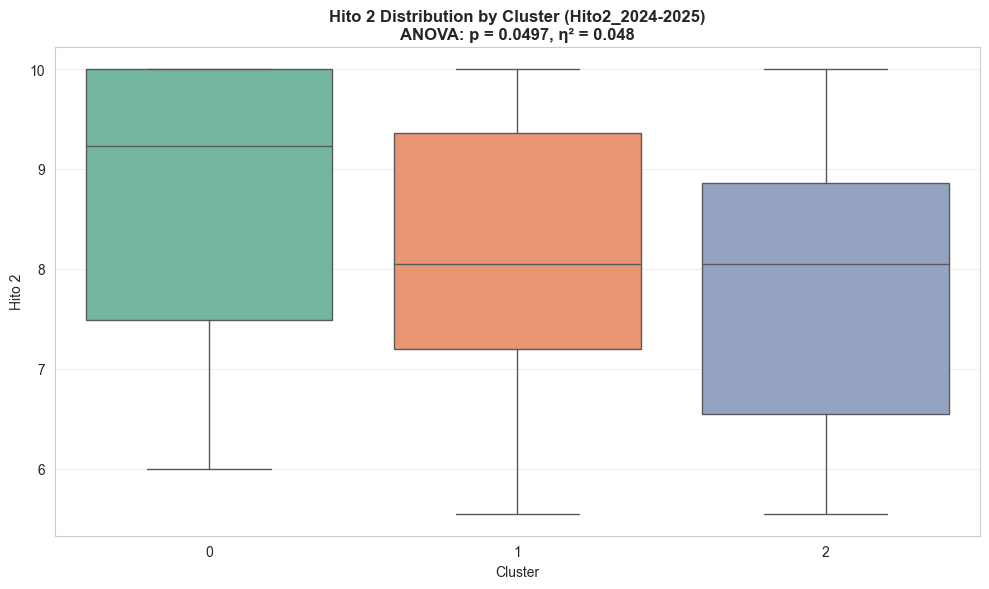


Performance Analysis: Hito 3 by Cluster (Hito3_2022-2023)

Descriptive Statistics:
         count  mean   std
Cluster                   
0           39  8.17  1.82
1           37  7.40  1.89
2           46  7.60  1.74

--- ANOVA Results ---
    Source  ddof1  ddof2         F     p-unc       np2
0  Cluster      2    119  1.856072  0.160781  0.030251

✗ No significant differences in Hito 3 between clusters (p = 0.1608)


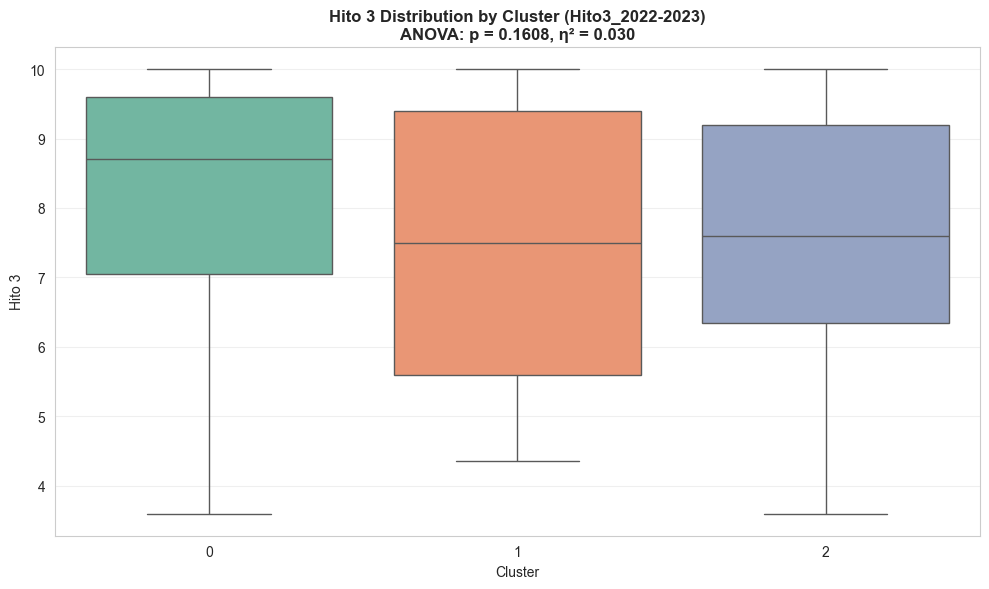


Performance Analysis: Hito 3 by Cluster (Hito3_2024-2025)

Descriptive Statistics:
         count  mean   std
Cluster                   
0          100  7.60  1.90
1           26  7.23  2.18
2            1  9.10   NaN

--- ANOVA Results ---
    Source  ddof1  ddof2         F     p-unc      np2
0  Cluster      2    124  0.688938  0.504021  0.01099

✗ No significant differences in Hito 3 between clusters (p = 0.5040)


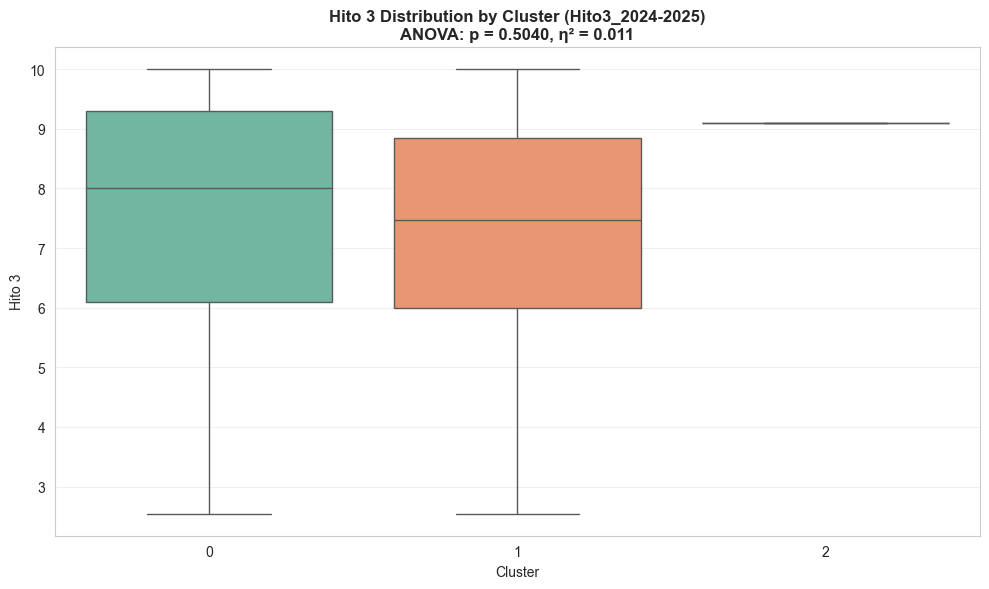


PERFORMANCE ANALYSIS SUMMARY
       Analysis Variable  p-value  Partial η² Significant
Hito1_2022-2023   Hito 1 0.284908    0.020881          No
Hito1_2024-2025   Hito 1 0.002383    0.092814         Yes
Hito2_2022-2023   Hito 2 0.158662    0.030721          No
Hito2_2024-2025   Hito 2 0.049740    0.047624         Yes
Hito3_2022-2023   Hito 3 0.160781    0.030251          No
Hito3_2024-2025   Hito 3 0.504021    0.010990          No


In [8]:
print("Analyzing academic performance by cluster...\n")

performance_results = []

for label, df in data_final.items():
    # Extract milestone number from label
    match = re.search(r'(Hito\d+)', label)
    if not match:
        continue
    
    hito_name = match.group(1)
    grade_column = hito_name.replace('Hito', 'Hito ')  # "Hito1" -> "Hito 1"
    
    if grade_column not in df.columns or 'Cluster' not in df.columns:
        print(f"Skipping {label}: missing required columns")
        continue
    
    print(f"\n{'='*70}")
    print(f"Performance Analysis: {grade_column} by Cluster ({label})")
    print('='*70)
    
    # Prepare data
    df_analysis = df.copy()
    df_analysis[grade_column] = pd.to_numeric(df_analysis[grade_column], errors='coerce')
    df_analysis = df_analysis.dropna(subset=[grade_column, 'Cluster'])
    
    if df_analysis.empty:
        print("No valid data for analysis.")
        continue
    
    # Descriptive statistics
    print(f"\nDescriptive Statistics:")
    desc_stats = df_analysis.groupby('Cluster')[grade_column].agg(['count', 'mean', 'std'])
    print(desc_stats.round(2))
    
    # ANOVA
    print(f"\n--- ANOVA Results ---")
    aov = pg.anova(data=df_analysis, dv=grade_column, between='Cluster')
    print(aov)
    
    p_value = aov['p-unc'].iloc[0]
    eta_sq = aov['np2'].iloc[0]
    
    # Store results
    performance_results.append({
        'Analysis': label,
        'Variable': grade_column,
        'p-value': p_value,
        'Partial η²': eta_sq,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })
    
    if p_value < 0.05:
        print(f"\n✓ Significant differences found (p = {p_value:.4f})")
        
        # Tukey HSD post-hoc
        print(f"\n--- Tukey HSD Post-Hoc ---")
        posthoc = pg.pairwise_tukey(data=df_analysis, dv=grade_column, between='Cluster')
        print(posthoc[['A', 'B', 'diff', 'p-tukey']].round(4))
    else:
        print(f"\n✗ No significant differences in {grade_column} between clusters (p = {p_value:.4f})")
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(
        data=df_analysis,
        x='Cluster',
        y=grade_column,
        palette='Set2',
        ax=ax
    )
    ax.set_title(
        f"{grade_column} Distribution by Cluster ({label})\n"
        f"ANOVA: p = {p_value:.4f}, η² = {eta_sq:.3f}",
        fontsize=12,
        fontweight='bold'
    )
    ax.set_xlabel('Cluster')
    ax.set_ylabel(grade_column)
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'performance_{label.replace("-", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Summary table
print("\n" + "="*70)
print("PERFORMANCE ANALYSIS SUMMARY")
print("="*70)
perf_df = pd.DataFrame(performance_results)
print(perf_df.to_string(index=False))

## 9. Cross-Cohort Performance Comparison

This section compares academic performance between different academic year cohorts to identify trends or changes over time.

### Methodology
- **Test**: Independent samples t-test
- **Comparison**: 2022-2023 cohort vs. 2024-2025 cohort
- **Variables**: Hito 1, Hito 2, Hito 3, Trabajo (final project)
- **Effect Size**: Cohen's d

### Cohen's d Interpretation
| Cohen's d | Interpretation |
|-----|----------------|
| ≥ 0.8 | Large effect |
| ≥ 0.5 | Medium effect |
| ≥ 0.2 | Small effect |
| < 0.2 | Negligible |

Creating master DataFrame for cross-cohort comparison...
Master DataFrame shape: (830, 41)
Cohorts: ['2022-2023' '2024-2025']

CROSS-COHORT COMPARISON: 2022-2023 vs 2024-2025

--- Hito 1 ---

2022-2023: n=365, mean=6.47, sd=1.03
2024-2025: n=380, mean=5.73, sd=1.70

T-test results:
             T       dof  p-val  cohen-d  power
T-test  7.2504  629.1697    0.0   0.5265    1.0

✓ Significant difference (p = 0.0000)
Effect size: MEDIUM (d = 0.526)


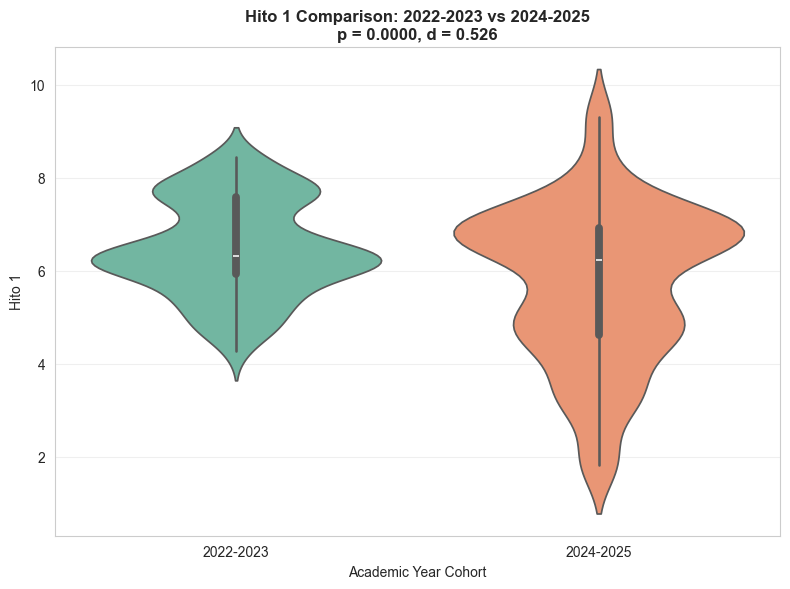


--- Hito 2 ---

2022-2023: n=365, mean=6.98, sd=1.76
2024-2025: n=380, mean=8.26, sd=1.38

T-test results:
              T       dof  p-val  cohen-d  power
T-test -11.0281  689.2396    0.0   0.8122    1.0

✓ Significant difference (p = 0.0000)
Effect size: LARGE (d = 0.812)


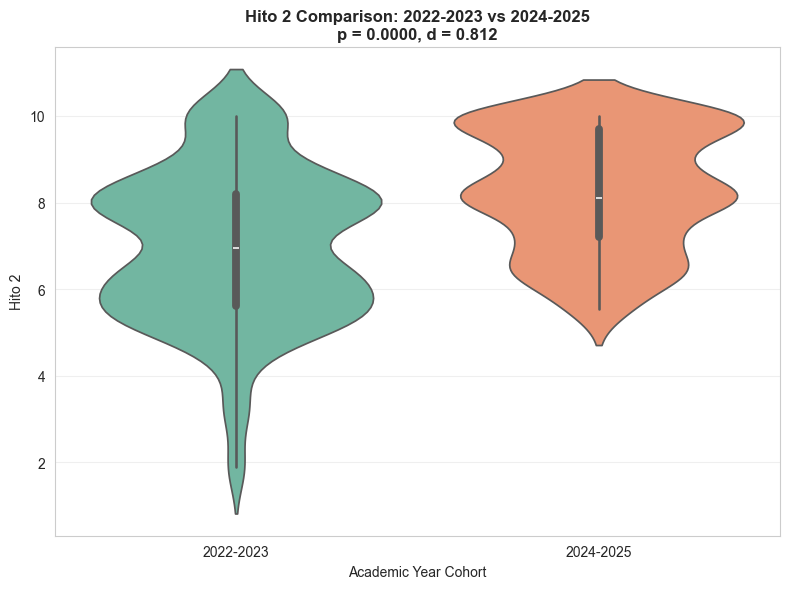


--- Hito 3 ---

2022-2023: n=365, mean=7.72, sd=1.82
2024-2025: n=380, mean=7.53, sd=1.95

T-test results:
             T       dof  p-val  cohen-d   power
T-test  1.3546  742.3773  0.176   0.0991  0.2717

✗ No significant difference (p = 0.1760)
Effect size: negligible (d = 0.099)


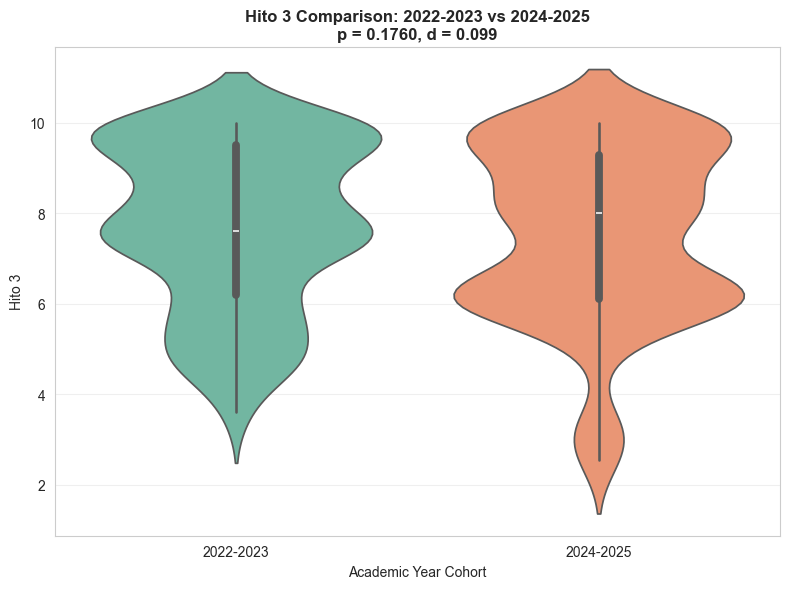


--- Trabajo ---

2022-2023: n=413, mean=8.34, sd=1.74
2024-2025: n=417, mean=8.55, sd=1.68

T-test results:
             T       dof  p-val  cohen-d   power
T-test -1.8078  826.0962  0.071   0.1255  0.4389

✗ No significant difference (p = 0.0710)
Effect size: negligible (d = 0.126)


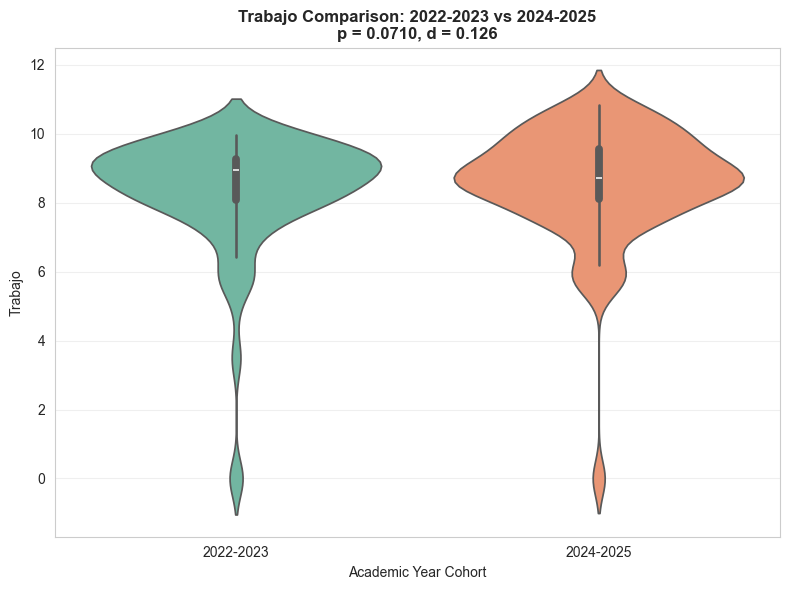


CROSS-COHORT COMPARISON SUMMARY
            Comparison Variable      p-value  Cohen's d Significant
2022-2023 vs 2024-2025   Hito 1 1.224355e-12   0.526452         Yes
2022-2023 vs 2024-2025   Hito 2 3.712236e-26   0.812162         Yes
2022-2023 vs 2024-2025   Hito 3 1.759539e-01   0.099140          No
2022-2023 vs 2024-2025  Trabajo 7.100124e-02   0.125524          No


In [9]:
# Create master DataFrame combining all data with cohort labels
print("Creating master DataFrame for cross-cohort comparison...")

all_data_list = []
for label, df in data_final.items():
    match = re.search(r'(\d{4})-(\d{4})', label)
    if match:
        cohort = f"{match.group(1)}-{match.group(2)}"
        df_copy = df.copy()
        df_copy['Cohort'] = cohort
        all_data_list.append(df_copy)

if all_data_list:
    master_df = pd.concat(all_data_list, ignore_index=True)
    print(f"Master DataFrame shape: {master_df.shape}")
    print(f"Cohorts: {master_df['Cohort'].unique()}")
else:
    print("ERROR: No data available for cross-cohort comparison.")
    master_df = pd.DataFrame()

# Perform cross-cohort comparisons
if not master_df.empty:
    cohort_1 = '2022-2023'
    cohort_2 = '2024-2025'
    variables_to_compare = ['Hito 1', 'Hito 2', 'Hito 3', 'Trabajo']
    
    print(f"\n{'='*70}")
    print(f"CROSS-COHORT COMPARISON: {cohort_1} vs {cohort_2}")
    print('='*70)
    
    cohort_results = []
    
    for var in variables_to_compare:
        print(f"\n--- {var} ---")
        
        df_comp = master_df[master_df['Cohort'].isin([cohort_1, cohort_2])].copy()
        df_comp[var] = pd.to_numeric(df_comp[var], errors='coerce')
        
        series_1 = df_comp[df_comp['Cohort'] == cohort_1][var].dropna()
        series_2 = df_comp[df_comp['Cohort'] == cohort_2][var].dropna()
        
        if series_1.empty or series_2.empty:
            print(f"Insufficient data for comparison.")
            continue
        
        # Descriptive statistics
        print(f"\n{cohort_1}: n={len(series_1)}, mean={series_1.mean():.2f}, sd={series_1.std():.2f}")
        print(f"{cohort_2}: n={len(series_2)}, mean={series_2.mean():.2f}, sd={series_2.std():.2f}")
        
        # T-test
        ttest = pg.ttest(series_1, series_2)
        p_val = ttest['p-val'].iloc[0]
        cohen_d = ttest['cohen-d'].iloc[0]
        
        print(f"\nT-test results:")
        print(ttest[['T', 'dof', 'p-val', 'cohen-d', 'power']].round(4))
        
        # Interpretation
        if p_val < 0.05:
            print(f"\n✓ Significant difference (p = {p_val:.4f})")
        else:
            print(f"\n✗ No significant difference (p = {p_val:.4f})")
        
        d_abs = abs(cohen_d)
        if d_abs >= 0.8:
            effect = 'LARGE'
        elif d_abs >= 0.5:
            effect = 'MEDIUM'
        elif d_abs >= 0.2:
            effect = 'SMALL'
        else:
            effect = 'negligible'
        print(f"Effect size: {effect} (d = {cohen_d:.3f})")
        
        cohort_results.append({
            'Comparison': f'{cohort_1} vs {cohort_2}',
            'Variable': var,
            'p-value': p_val,
            "Cohen's d": cohen_d,
            'Significant': 'Yes' if p_val < 0.05 else 'No'
        })
        
        # Visualization
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.violinplot(
            data=df_comp,
            x='Cohort',
            y=var,
            palette='Set2',
            ax=ax
        )
        ax.set_title(
            f"{var} Comparison: {cohort_1} vs {cohort_2}\n"
            f"p = {p_val:.4f}, d = {cohen_d:.3f}",
            fontsize=12,
            fontweight='bold'
        )
        ax.set_xlabel('Academic Year Cohort')
        ax.set_ylabel(var)
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Summary
    print("\n" + "="*70)
    print("CROSS-COHORT COMPARISON SUMMARY")
    print("="*70)
    cohort_df = pd.DataFrame(cohort_results)
    print(cohort_df.to_string(index=False))

## 10. Consolidated Results Summary

This section generates a unified summary table of all statistical analyses performed, suitable for inclusion in research publications.

In [12]:
print("Generating consolidated results summary...")

final_summary = []

# Analysis 1: Performance by Cluster
print("\nCompiling Analysis 1: Performance by Cluster...")
for label, df in data_final.items():
    match = re.search(r'(Hito\d+)', label)
    if not match:
        continue
    
    hito_name = match.group(1)
    grade_column = hito_name.replace('Hito', 'Hito ')
    
    if grade_column not in df.columns or 'Cluster' not in df.columns:
        continue
    
    df_analysis = df.dropna(subset=[grade_column, 'Cluster']).copy()
    if df_analysis.empty:
        continue
    
    # Ensure the DV (grade_column) is numeric
    # (this also handles decimal commas like "8,5" → "8.5")
    df_analysis[grade_column] = (
        df_analysis[grade_column]
        .astype(str)
        .str.replace(',', '.', regex=False)
    )
    df_analysis[grade_column] = pd.to_numeric(df_analysis[grade_column], errors='coerce')
    
    # Drop rows that could not be converted to numbers
    df_analysis = df_analysis.dropna(subset=[grade_column])
    if df_analysis.empty:
        continue
    
    aov = pg.anova(data=df_analysis, dv=grade_column, between='Cluster')

    p_value = aov['p-unc'].iloc[0]
    eta_sq = aov['np2'].iloc[0]
    
    # Handle marginal significance
    if p_value < 0.05:
        if 0.049 <= p_value <= 0.051:
            is_sig = 'Yes (marginal)'
        else:
            is_sig = 'Yes'
    else:
        is_sig = 'No'
    
    final_summary.append({
        'Analysis Type': 'Performance by Cluster',
        'Dataset': label,
        'Variable': grade_column,
        'Statistical Test': 'ANOVA',
        'p-value': p_value,
        'Effect Size': eta_sq,
        'Effect Metric': 'η²p',
        'Significant (p < 0.05)': is_sig
    })

# Analysis 2: Cross-Cohort Comparison
print("Compiling Analysis 2: Cross-Cohort Comparison...")
if not master_df.empty:
    cohort_1, cohort_2 = '2022-2023', '2024-2025'
    
    for var in ['Hito 1', 'Hito 2', 'Hito 3', 'Trabajo']:
        df_comp = master_df[master_df['Cohort'].isin([cohort_1, cohort_2])].copy()
        df_comp[var] = pd.to_numeric(df_comp[var], errors='coerce')
        
        s1 = df_comp[df_comp['Cohort'] == cohort_1][var].dropna()
        s2 = df_comp[df_comp['Cohort'] == cohort_2][var].dropna()
        
        if s1.empty or s2.empty:
            continue
        
        ttest = pg.ttest(s1, s2)
        p_val = ttest['p-val'].iloc[0]
        cohen_d = ttest['cohen-d'].iloc[0]
        
        final_summary.append({
            'Analysis Type': 'Cross-Cohort Comparison',
            'Dataset': f'{cohort_1} vs {cohort_2}',
            'Variable': var,
            'Statistical Test': 'T-test',
            'p-value': p_val,
            'Effect Size': cohen_d,
            'Effect Metric': "Cohen's d",
            'Significant (p < 0.05)': 'Yes' if p_val < 0.05 else 'No'
        })

# Display and export
if final_summary:
    summary_table = pd.DataFrame(final_summary)
    
    print("\n" + "="*100)
    print("CONSOLIDATED STATISTICAL RESULTS")
    print("="*100)
    
    # Styled display
    def highlight_significance(row):
        styles = [''] * len(row)
        sig_idx = row.index.get_loc('Significant (p < 0.05)')
        
        if row['Significant (p < 0.05)'] == 'Yes':
            styles[sig_idx] = 'background-color: #d4edda; color: #155724; font-weight: bold'
        elif row['Significant (p < 0.05)'] == 'Yes (marginal)':
            styles[sig_idx] = 'background-color: #fff3cd; color: #856404; font-weight: bold'
        
        return styles
    
    styled = summary_table.style.apply(highlight_significance, axis=1)
    display(styled)
    
    # Handle marginal significance notes
    marginal = summary_table[summary_table['Significant (p < 0.05)'] == 'Yes (marginal)']
    if not marginal.empty:
        print("\n" + "-"*100)
        print("NOTE ON MARGINAL SIGNIFICANCE:")
        print("-"*100)
        for _, row in marginal.iterrows():
            print(f"• {row['Dataset']} ({row['Variable']}): p = {row['p-value']:.6f}")
            print(f"  → Technically significant (p ≤ 0.05), but at the threshold.")
            print(f"  → Interpret with caution; consider replication.")
        print("-"*100)
    
    # Export to CSV
    output_path = 'statistical_results_summary.csv'
    summary_table.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"\n✓ Results exported to: {output_path}")
else:
    print("\nNo results to summarize.")

Generating consolidated results summary...

Compiling Analysis 1: Performance by Cluster...
Compiling Analysis 2: Cross-Cohort Comparison...

CONSOLIDATED STATISTICAL RESULTS


,Analysis Type,Dataset,Variable,Statistical Test,p-value,Effect Size,Effect Metric,Significant (p < 0.05)
0,Performance by Cluster,Hito1_2022-2023,Hito 1,ANOVA,0.284908,0.020881,η²p,No
1,Performance by Cluster,Hito1_2024-2025,Hito 1,ANOVA,0.002383,0.092814,η²p,Yes
2,Performance by Cluster,Hito2_2022-2023,Hito 2,ANOVA,0.158662,0.030721,η²p,No
3,Performance by Cluster,Hito2_2024-2025,Hito 2,ANOVA,0.049740,0.047624,η²p,Yes (marginal)
4,Performance by Cluster,Hito3_2022-2023,Hito 3,ANOVA,0.160781,0.030251,η²p,No
5,Performance by Cluster,Hito3_2024-2025,Hito 3,ANOVA,0.504021,0.010990,η²p,No
6,Cross-Cohort Comparison,2022-2023 vs 2024-2025,Hito 1,T-test,0.000000,0.526452,Cohen's d,Yes
7,Cross-Cohort Comparison,2022-2023 vs 2024-2025,Hito 2,T-test,0.000000,0.812162,Cohen's d,Yes
8,Cross-Cohort Comparison,2022-2023 vs 2024-2025,Hito 3,T-test,0.175954,0.099140,Cohen's d,No
9,Cross-Cohort Comparison,2022-2023 vs 2024-2025,Trabajo,T-test,0.071001,0.125524,Cohen's d,No



----------------------------------------------------------------------------------------------------
NOTE ON MARGINAL SIGNIFICANCE:
----------------------------------------------------------------------------------------------------
• Hito2_2024-2025 (Hito 2): p = 0.049740
  → Technically significant (p ≤ 0.05), but at the threshold.
  → Interpret with caution; consider replication.
----------------------------------------------------------------------------------------------------

✓ Results exported to: statistical_results_summary.csv


## 11. Reproducibility Information

Environment and configuration details for methods documentation.

In [13]:
from datetime import datetime
import sklearn

print("REPRODUCIBILITY INFORMATION")
print("="*50)
print(f"Timestamp: {datetime.now().isoformat(timespec='seconds')}")
print(f"\nLibrary Versions:")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  scikit-learn: {sklearn.__version__}")
print(f"  pingouin: {pg.__version__}")
print(f"  seaborn: {sns.__version__}")
print(f"\nAnalysis Parameters:")
print(f"  Optimal K: {OPTIMAL_K}")
print(f"  K Range Tested: {list(K_RANGE)}")
print(f"  Missing Threshold: {MISSING_THRESHOLD:.0%}")
print(f"  Year Pairs: {YEAR_PAIRS_TO_CREATE}")
print(f"  Random State: 42 (K-Means)")

REPRODUCIBILITY INFORMATION
Timestamp: 2025-12-11T13:29:58

Library Versions:
  pandas: 2.3.3
  numpy: 2.3.5
  scikit-learn: 1.7.2
  pingouin: 0.5.5
  seaborn: 0.13.2

Analysis Parameters:
  Optimal K: 3
  K Range Tested: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Missing Threshold: 50%
  Year Pairs: [(2022, 2023), (2024, 2025)]
  Random State: 42 (K-Means)


## Appendix: Methods Summary for Publication

### Clustering Methodology

Student behavioral patterns were identified using K-Means clustering on PCA-reduced feature spaces. Features with >50% missing values were excluded prior to analysis. All features were standardized (z-score normalization) before dimensionality reduction. The optimal number of clusters (k=3) was determined using the elbow method, evaluating within-cluster sum of squares (WCSS) for k ∈ [1, 10].

### Statistical Validation

Cluster validity was assessed using:
1. **MANOVA**: Multivariate test of cluster centroid differences (Wilks' λ)
2. **Univariate ANOVA**: Per-feature tests with partial η² effect sizes
3. **Tukey HSD**: Pairwise comparisons with family-wise error control

### Performance Analysis

The association between behavioral clusters and academic performance was tested using one-way ANOVA for each milestone grade. Cross-cohort comparisons (2022-2023 vs. 2024-2025) used independent samples t-tests with Cohen's d effect sizes.

### Effect Size Interpretation

Effect sizes were interpreted following Cohen (1988):
- Partial η²: 0.01 (small), 0.06 (medium), 0.14 (large)
- Cohen's d: 0.2 (small), 0.5 (medium), 0.8 (large)

### Software

Analysis was performed in Python using scikit-learn (clustering, PCA), pingouin (statistical tests), and statsmodels (MANOVA). Random seed was fixed at 42 for reproducibility.